# Demonstrate Positional Bias

Our goal here is to quantify positional bias inherrent in our LLM.

# Setup

In [24]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
import logging
from pathlib import Path
from time import perf_counter_ns as timer

from pandas import DataFrame
import rich
from rich.table import Table
from tqdm import tqdm

import llm_mcq_bias as lmb
from llm_mcq_bias.datasets.mmlu import Evaluation, OPTIONS
from llm_mcq_bias.models import gpt_4o_mini as generator

In [18]:
def print_table(rows, title: str | None = None):
    table = Table(*[k for k in rows[0]], title=title, box=rich.box.SIMPLE)
    for row in rows:
        table.add_row(*[str(v) for v in row.values()])
    rich.print(table)

In [3]:
project_path = Path("../")
datasets_path = project_path / ".build" / "datasets"

logger = logging.getLogger(__name__)

In [4]:
# Warm up model
generator(
    prompt="What is the capital of Massachusetts? Answer in one word.",
    options={"max_tokens": 1},
)

'Boston'

# Demonstrate Bias

In [5]:
# Number of iterations
n_epochs = 3

# Number of questions to sample
n_questions = 240

# Number of workers
n_jobs = 3

llm_options = {
    # Limit output tokens to avoid waiting for invalid responses
    "max_tokens": 10,
    # Disable token sampling
    "temperature": 0.0,
    "top_p": 1.0,
}

In [6]:
# Load example questions
examples = lmb.datasets.mmlu.load_dataset(datasets_path, segment="dev")

# Debias example answer distribution
examples = lmb.datasets.mmlu.normalize_example_answers(examples)

# Load test questions
questions = lmb.datasets.mmlu.load_dataset(datasets_path, segment="test")

# Initialize thread pool
executor = ThreadPoolExecutor(max_workers=n_jobs)

In [7]:
def process_mcq(generator, generator_options, mcq):
    # Generate prompt
    prompt = lmb.datasets.mmlu.generate_prompt(examples, mcq)

    # Generate answer
    response = generator(prompt=prompt, options=generator_options)

    # Evaluate response
    evaluation = lmb.datasets.mmlu.evaluate_response(mcq, response)

    return evaluation


def benchmark(
    description: str,
    *,
    examples: DataFrame,
    questions: DataFrame,
    generator,
    generator_options: dict,
):
    n = len(questions)

    start_time = timer()

    # Answer and evaluate each question
    futures = [
        executor.submit(process_mcq, generator, generator_options, mcq)
        for _, mcq in questions.iterrows()
    ]

    # Collect results
    correct, errors = 0, 0
    for future in tqdm(as_completed(futures), total=n, desc=description):
        evaluation = future.result()
        if evaluation is Evaluation.CORRECT:
            correct += 1
        elif evaluation is Evaluation.ERROR:
            errors += 1

    duration = timer() - start_time

    # Derive metrics
    metrics = {
        "n": n,
        "correct": correct,
        "errors": errors,
        "accuracy": correct / (n - errors),
        "error_rate": errors / n,
        "rps": 1000000000 * n / duration,
    }

    return metrics

### Verify Stable Benchmark Results

Let's make sure our benchmark process produces consistent results when run against the same inputs.

<Axes: xlabel='answer'>

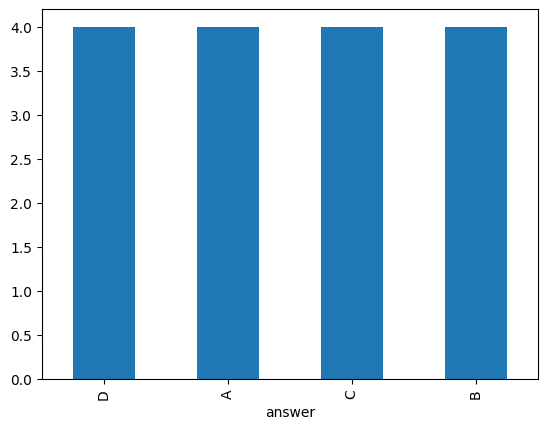

In [8]:
# Sample questions
selected_questions = questions.sample(n=16)

# Debias answer distribution
selected_questions = lmb.datasets.mmlu.normalize_question_answers(selected_questions)

# Plot answer distribution
selected_questions.answer.value_counts().plot.bar()

In [9]:
# Print example prompt
print(lmb.datasets.mmlu.generate_prompt(examples, selected_questions.iloc[0]))

You are a robot that only outputs JSON. You reply in JSON format with the field 'answer'. For example, the following are multiple choice questions about high school biology.

Example Question: Which of the following is not known to be involved in the control of cell division?

A) Cyclins
B) Fibroblast cells
C) Checkpoints
D) Protein kinases

Example Answer: {"answer": "B"}

Example Question: Which of the following is not a way to form recombinant DNA?

A) Specialized transduction
B) Conjugation
C) Translation
D) Transformation

Example Answer: {"answer": "C"}

Example Question: In animal cells, which of the following represents the most likely pathway that a secretory protein takes as it is synthesized in a cell?

A) Plasma membrane–Golgi apparatus–ribosome–secretory vesicle–rough ER
B) Ribosome–Golgi apparatus–rough ER–secretory vesicle–plasma membrane
C) Plasma membrane–Golgi apparatus–ribosome–secretory vesicle–rough ER
D) Ribosome–rough ER–Golgi apparatus–secretory vesicle–plasma m

In [10]:
%%time

rows = []
for i in range(n_epochs):
    # Run benchmark
    metrics = benchmark(
        f"epoch {i}",
        examples=examples,
        questions=selected_questions,
        generator=generator,
        generator_options=llm_options,
    )

    rows.append(metrics)

print_table(rows)

epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.45it/s]


 n    correct   errors   accuracy   error_rate   rps                
 ─────────────────────────────────────────────────────────────────── 
  16   13        0        0.8125     0.0          6.574058982499922  
  16   13        0        0.8125     0.0          5.787201229614747  
  16   13        0        0.8125     0.0          6.41856819634496

CPU times: user 1.92 s, sys: 52.5 ms, total: 1.97 s
Wall time: 7.73 s


stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_scheduled
stamina.retry_sc

## Estimate Positional Bias

In [11]:
%%time

# Repeat over multiple iterations
rows = []
for _ in range(n_epochs):
    # Sample questions
    selected_questions = questions.sample(n=n_questions)

    # Debias answer distribution
    selected_questions = lmb.datasets.mmlu.normalize_question_answers(
        selected_questions
    )

    # Initialize metrics
    metrics = {}

    # Record performance w/ original data
    metrics["uniform"] = benchmark(
        "uniform",
        examples=examples,
        questions=selected_questions,
        generator=generator,
        generator_options=llm_options,
    )

    # Record performance w/ answers shifted to each position
    for option in OPTIONS:
        # Swap answers to selected option
        q = lmb.datasets.mmlu.swap_options(selected_questions, option)

        metrics[option] = benchmark(
            option,
            examples=examples,
            questions=q,
            generator=generator,
            generator_options=llm_options,
        )

    rows.append(metrics)

C: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [01:46<00:00,  2.25it/s]

CPU times: user 2min 9s, sys: 3.14 s, total: 2min 12s
Wall time: 11min 48s


In [20]:
keys = [k for k in rows[0]]

for k in keys:
    print_table([row[k] for row in rows], title=k)

                                         uniform                                          
                                                                                          
  n     correct   errors   accuracy             error_rate             rps                
 ──────────────────────────────────────────────────────────────────────────────────────── 
  240   188       1        0.7866108786610879   0.004166666666666667   5.980479845653368  
  240   192       1        0.803347280334728    0.004166666666666667   6.158617979124051  
  240   186       0        0.775                0.0                    5.16404290959638

                                             D                                             
                                                                                           
  n     correct   errors   accuracy             error_rate             rps                 
 ───────────────────────────────────────────────────────────────────────────────────────── 
  240   167       0        0.6958333333333333   0.0                    5.9047667839035025  
  240   175       0        0.7291666666666666   0.0                    6.480192588926071   
  240   170       1        0.7112970711297071   0.004166666666666667   5.243543707366408

                                        B                                        
                                                                                 
  n     correct   errors   accuracy             error_rate   rps                 
 ─────────────────────────────────────────────────────────────────────────────── 
  240   185       0        0.7708333333333334   0.0          6.309858661682298   
  240   191       0        0.7958333333333333   0.0          5.6029896973489155  
  240   193       0        0.8041666666666667   0.0          5.208531106956295

                                            A                                             
                                                                                          
  n     correct   errors   accuracy             error_rate             rps                
 ──────────────────────────────────────────────────────────────────────────────────────── 
  240   186       0        0.775                0.0                    6.05992985491663   
  240   197       1        0.8242677824267782   0.004166666666666667   4.765114617424156  
  240   188       0        0.7833333333333333   0.0                    5.001953064260789

                                             C                                             
                                                                                           
  n     correct   errors   accuracy             error_rate             rps                 
 ───────────────────────────────────────────────────────────────────────────────────────── 
  240   182       0        0.7583333333333333   0.0                    6.4130559832553224  
  240   185       0        0.7708333333333334   0.0                    4.806972580930116   
  240   189       1        0.7907949790794979   0.004166666666666667   2.245580981522416

In [21]:
table = Table("uniform", "A", "B", "C", "D", box=rich.box.SIMPLE)
for row in rows:
    baseline = row["uniform"]["accuracy"]
    offsets = {k: row[k]["accuracy"] - baseline for k in OPTIONS}
    colors = {option: "black" for option in OPTIONS}
    colors |= {option: "red" for option in OPTIONS if offsets[option] <= -0.05}
    colors |= {option: "green" for option in OPTIONS if offsets[option] >= 0.05}
    table.add_row(
        f"{baseline:0.2f}",
        f"[{colors['A']}]{offsets['A']:0.2f}[/{colors['A']}]",
        f"[{colors['B']}]{offsets['B']:0.2f}[/{colors['B']}]",
        f"[{colors['C']}]{offsets['C']:0.2f}[/{colors['C']}]",
        f"[{colors['D']}]{offsets['D']:0.2f}[/{colors['D']}]",
    )

rich.print(table)

 uniform   A       B       C       D      
 ───────────────────────────────────────── 
  0.79      -0.01   -0.02   -0.03   -0.09  
  0.80      0.02    -0.01   -0.03   -0.07  
  0.78      0.01    0.03    0.02    -0.06

# Export Results

In [26]:
path = Path("results/demonstrate-bias-gpt-4o-mini-run1.json")
path.write_text(json.dumps(rows))

1928